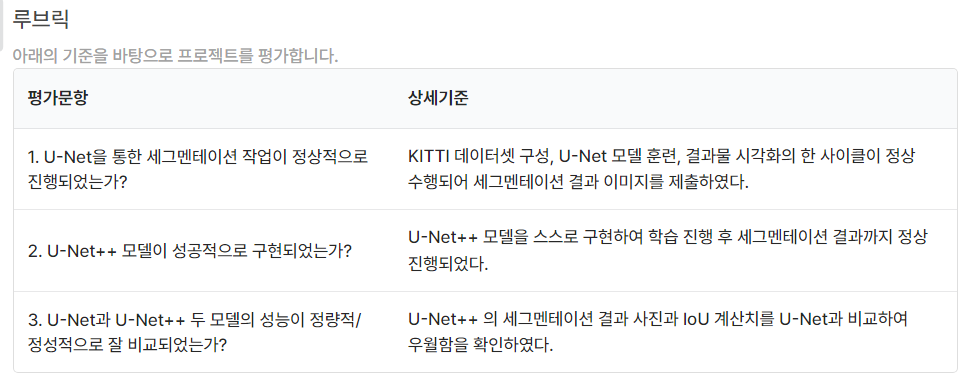

$ pip list | grep albumentations

데이터 로더 입력값 출력값 둘다 224, 224

augmentation - albumentation 적용하자

학습셋의 일정량을 검증 데이터셋으로 활용할수 있도록 해야한다.



In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

Albumentation에서 다양한 <b>augmentation 기법을 확률적으로 적용</b>할 수 있게 해주는 Compose()의 활용예입니다. 
    
imgaug의 Sometimes()와 유사한 기능입니다.

# Compose를 통해 다양한 augmentation을 train에 적용한다

In [2]:
from albumentations import HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resizegf

In [3]:
def build_augmentation(is_train=True):
    if is_train: # 훈련용 데이터만 플립, 랜덤사이즈크롭 적용
        return Compose([
            HorizontalFlip(p=0.5), 
            RandomSizedCrop(
                min_max_height=(300,370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(
                width=224,
                height=224,
            )
        ])
    return Compose([ #Resize는 공통적용
        Resize(
            width=224,
            height=224
        )
        
    ])
        

augmentation을 train과 test에 각각 적용한 후, glob을 통해 파일 디렉토리 내의 png 파일을 가져온다

그 후 plt로 시각화를 한다 



[[[ 12  12  13]
  [ 12  12  14]
  [ 11  14  14]
  ...
  [241 255 255]
  [239 255 255]
  [234 255 255]]

 [[ 12  13  12]
  [ 12  13  14]
  [ 11  13  14]
  ...
  [240 255 255]
  [236 255 255]
  [230 255 255]]

 [[  9  12  12]
  [  9  12  14]
  [ 10  12  14]
  ...
  [240 255 255]
  [237 255 255]
  [235 255 255]]

 ...

 [[ 93 106 122]
  [ 88 106 112]
  [ 94 104 107]
  ...
  [103 102 105]
  [ 98 102 106]
  [ 96 104 105]]

 [[ 83  99 113]
  [ 83  98 119]
  [ 96 105 123]
  ...
  [104 100 100]
  [ 99  99 101]
  [ 94 100 101]]

 [[113 110 111]
  [117 112 121]
  [115 122 122]
  ...
  [ 95 100 100]
  [ 96  99 100]
  [ 97  99  99]]]
[[[ 29  33  27]
  [ 29  35  38]
  [ 33  40  39]
  ...
  [101 156 227]
  [100 157 225]
  [ 99 157 225]]

 [[ 29  38  29]
  [ 28  40  29]
  [ 32  38  29]
  ...
  [104 158 227]
  [102 159 226]
  [ 99 159 226]]

 [[ 32  41  29]
  [ 32  40  28]
  [ 32  36  26]
  ...
  [103 157 228]
  [102 159 227]
  [ 99 159 227]]

 ...

 [[100 103  88]
  [103 102  96]
  [109 106 100]
  ..

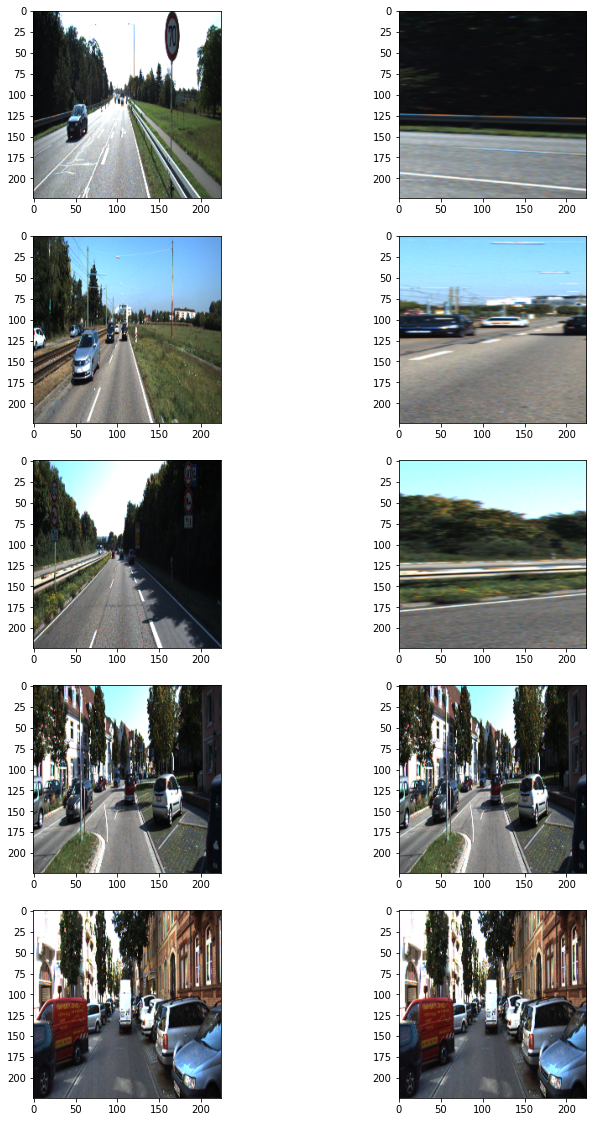

In [4]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(False)    
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

#훈련 데이터셋에서 5개만 가져와서 어그멘테이션 적용하자
plt.figure(figsize=(12,20))

for i in range(5):
    image = imread(input_images[i])
    print(image)
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5,2,2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5,2,2*i+2)
    plt.imshow(processed["image"])

plt.show()





**image_data 를 쓰는건 몇개 들어올지 모르나 여러개 파라미터를 넘겨준다는 뜻이다
https://scikit-image.org/docs/stable/api/skimage.io.html

skimage.io.imread(fname[, as_gray, plugin])

Load an image from file.

args ? kwargs ? 이거보면 해결 -> arguments와  keyward arguments다. 즉 is_true=True 이런식으로 선언해야되는 부분은 kwargs로 분류되는것

https://jhproject.tistory.com/109

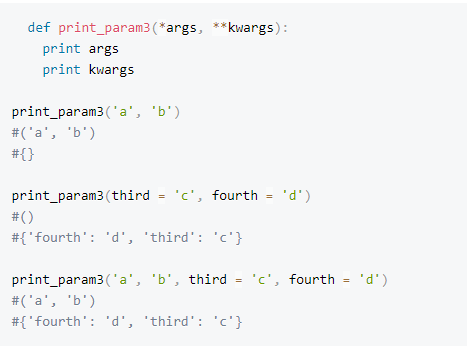


In [5]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                dir_path,
                 batch_size=16,
                 img_size=(224,224,3),
                 output_size=(224,224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        #load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인한다
        self.data = self.load_dataset()
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png")) #전처리에 사용할 입력이미지 경로!
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png")) #정답 이미지
        
        input_images.sort()
        label_images.sort()
        
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)] #input당 label을 data에 배열로 정렬해서 넣음
        
        if self.is_train: #train이라면
            return data[:-30] # 끝에서 30개는 test용으로 남기고 나머지 모두 train
        
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        #입력과 출력을 만든다
        #입력은 resize, segmentation이 적용된 input image
        #출력은 semantic label - semantic segmentation ?
        
        batch_data = self.data[
            index * self.batch_size : (index + 1) * self.batch_size # 데이터 인덱스 슬라이싱
        ]
        inputs = np.zeros([self.batch_size , *self.img_size]) #뭐.. args만 받는다는 것인가??ㅋㅋㅋㅋ 돌겟다!!
        outputs = np.zeros([self.batch_size , *self.output_size])
        
        #print(inputs)
        
        for i , data in enumerate(batch_data):
            input_img_path , output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output,   
            }
            augmented = self.augmentation(**data) #kwargs만 받는다
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs
        
    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train==True:
            np.random.shuffle(self.indexes)
            return self.indexes
            

            
            
        
        
            
        
        
        
        

In [6]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

# 8-3. 시맨틱 세그멘테이션 모델

u-net 모델로 만들어보자

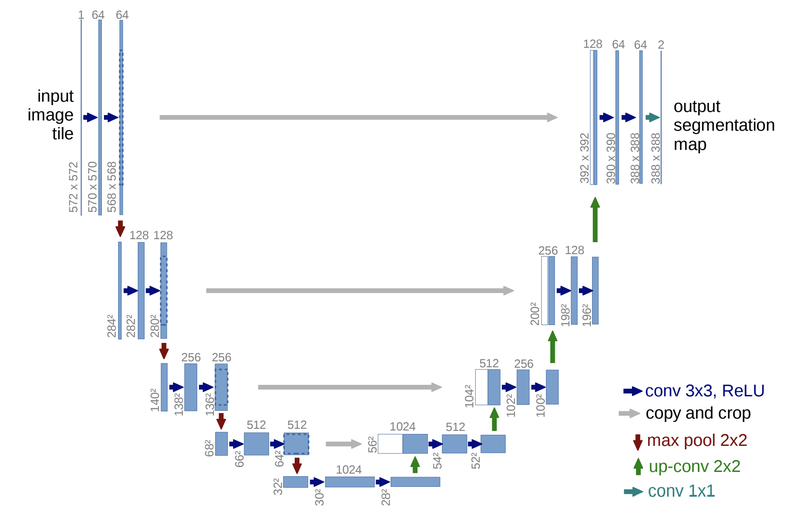

In [8]:
def build_model(input_shape=(224,224,3)):
    inputs = Input(input_shape) #224
    
    #U-net Contracting Path
    conv1_1 = Conv2D(64, 3, activation='relu', kernel_initializer="he_normal")(inputs) #222
    conv1_2 = Conv2D(64, 3, activation='relu', kernel_initializer="he_normal")(conv1_1) #220
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1_2) #110
    #dropout?
    conv2_1 = Conv2D(128, 3, activation='relu', kernel_initializer="he_normal")(pool1) #108
    conv2_2 = Conv2D(128, 3, activation='relu', kernel_initializer="he_normal")(conv2_1) #106
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2_2) #53
    #dropout?
    conv3_1 = Conv2D(256, 3, activation='relu', kernel_initializer="he_normal")(pool2) #51
    conv3_2 = Conv2D(256, 3, activation='relu', kernel_initializer="he_normal")(conv3_1) # 49
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3_2) # 24
    #dropout?
    conv4_1 = Conv2D(512, 3, activation='relu', kernel_initializer="he_normal")(pool3) # 22
    conv4_2 = Conv2D(512, 3, activation='relu', kernel_initializer="he_normal")(conv4_1) # 20
    #drop???
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4_2) # 10 
    
    conv5_1 = Conv2D(1024, 3, activation='relu', kernel_initializer="he_normal")(pool4) # 8 
    conv5_2 = Conv2D(1024, 3, activation='relu', kernel_initializer="he_normal")(conv5_1) # 6
    
    #U-net Expanding Path
    drop5 = Dropout(0.5)(conv5_2)
    upconv6 = Conv2DTranspose(512, 2, activation="relu", strides=(2,2), kernel_initializer="he_normal")(drop5) # 12
    concat6 = concatenate([conv4_2, upconv6], axis=3) # 20 and 12 ? not matched
    conv6_1 = Conv2D(512, 3, activation='relu', kernel_initializer="he_normal")(concat6)
    conv6_2 = Conv2D(512, 3, activation='relu', kernel_initializer="he_normal")(conv6_1)
    
    upconv7 = Conv2DTranspose(256, 2, activation="relu", strides=(2,2), kernel_initializer="he_normal")(conv6_2)
    concat7 = concatenate([conv3_2, upconv7], axis=3)
    conv7_1 = Conv2D(256, 3, activation='relu', kernel_initializer="he_normal")(concat7)
    conv7_2 = Conv2D(256, 3, activation='relu', kernel_initializer="he_normal")(conv7_1)
    
    upconv8 = Conv2DTranspose(128, 2, activation="relu", strides=(2,2), kernel_initializer="he_normal")(conv7_2)
    concat8 = concatenate([conv2_2, upconv8], axis=3)
    conv8_1 = Conv2D(128, 3, activation='relu', kernel_initializer="he_normal")(concat8)
    conv8_2 = Conv2D(128, 3, activation='relu', kernel_initializer="he_normal")(conv8_1)
    
    upconv9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv8_2)
    concat9 = concatenate([conv1_2, upconv9], axis=3)
    conv9_1 = Conv2D(64, 3, activation='relu', kernel_initializer="he_normal")(concat9)
    conv9_2 = Conv2D(64, 3, activation='relu', kernel_initializer="he_normal")(conv9_1)
    
    conv9_3 = Conv2D(2, 3, activation='relu', kernel_initializer="he_normal")(conv9_2)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9_3)
    
    model = Model(inputs=inputs, outputs= conv10)
    
    return model

    

# 모델 확인 with h5

In [9]:
model_path = os.getenv("HOME") + '/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy')
model.fit(
    train_generator,
    validation_data = test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

model.save(model_path)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 20, 20, 512), (None, 12, 12, 512)]

패딩이 없어서 사이즈가 맞지않아 concate이 되지않는다 그래서 padding="same"을 추가한 코드로 수행한다

In [10]:
def build_model(input_shape=(224,224,3)):
    inputs = Input(input_shape) #224
    
    #U-net Contracting Path
    conv1_1 = Conv2D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal")(inputs) #224
    conv1_2 = Conv2D(64, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv1_1) #224
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1_2) #112
    #dropout?
    conv2_1 = Conv2D(128, 3, activation='relu', padding="same",kernel_initializer="he_normal")(pool1) #112
    conv2_2 = Conv2D(128, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv2_1) #112
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2_2) #56
    #dropout?
    conv3_1 = Conv2D(256, 3, activation='relu', padding="same",kernel_initializer="he_normal")(pool2) #56
    conv3_2 = Conv2D(256, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv3_1) # 56
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3_2) # 28
    #dropout?
    conv4_1 = Conv2D(512, 3, activation='relu', padding="same",kernel_initializer="he_normal")(pool3) # 28
    conv4_2 = Conv2D(512, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv4_1) # 28
    #drop???
    pool4 = MaxPooling2D(pool_size=(2,2))(conv4_2) # 14
    
    conv5_1 = Conv2D(1024, 3, activation='relu', padding="same",kernel_initializer="he_normal")(pool4) # 14
    conv5_2 = Conv2D(1024, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv5_1) # 14
    
    #U-net Expanding Path
    drop5 = Dropout(0.5)(conv5_2)
    upconv6 = Conv2DTranspose(512, 2, activation="relu", strides=(2,2), kernel_initializer="he_normal")(drop5) # 14
    concat6 = concatenate([conv4_2, upconv6], axis=3) # 20 and 12 ? not matched  -> 14 and 14
    conv6_1 = Conv2D(512, 3, activation='relu', padding="same",kernel_initializer="he_normal")(concat6) #28
    conv6_2 = Conv2D(512, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv6_1) #28
    
    upconv7 = Conv2DTranspose(256, 2, activation="relu", strides=(2,2), kernel_initializer="he_normal")(conv6_2) #28
    concat7 = concatenate([conv3_2, upconv7], axis=3) #56
    conv7_1 = Conv2D(256, 3, activation='relu', padding="same",kernel_initializer="he_normal")(concat7) #56
    conv7_2 = Conv2D(256, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv7_1) #56
    
    upconv8 = Conv2DTranspose(128, 2, activation="relu", strides=(2,2), kernel_initializer="he_normal")(conv7_2) #56
    concat8 = concatenate([conv2_2, upconv8], axis=3) #112
    conv8_1 = Conv2D(128, 3, activation='relu', padding="same",kernel_initializer="he_normal")(concat8) #112
    conv8_2 = Conv2D(128, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv8_1) #112
    
    upconv9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv8_2) #112
    concat9 = concatenate([conv1_2, upconv9], axis=3) # 224
    conv9_1 = Conv2D(64, 3, activation='relu', padding="same",kernel_initializer="he_normal")(concat9) #224
    conv9_2 = Conv2D(64, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv9_1) #224
    
    conv9_3 = Conv2D(2, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv9_2) #224
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9_3) #1
    
    model = Model(inputs=inputs, outputs= conv10)
    
    return model

    

# 모델 학습

In [11]:
model_path = os.getenv("HOME") + '/aiffel/semantic_segmentation/seg_model_unet.h5'

model = build_model()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy')
model.fit(
    train_generator,
    validation_data = test_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
)

model.save(model_path)

Epoch 1/100
11/11 [==============================] - 51s 623ms/step - loss: 0.6910 - val_loss: 0.6843
Epoch 2/100
11/11 [==============================] - 7s 600ms/step - loss: 0.6779 - val_loss: 0.6563
Epoch 3/100
11/11 [==============================] - 7s 600ms/step - loss: 0.3469 - val_loss: 0.0318
Epoch 4/100
11/11 [==============================] - 6s 588ms/step - loss: 0.0309 - val_loss: 0.0334
Epoch 5/100
11/11 [==============================] - 6s 587ms/step - loss: 0.0325 - val_loss: 0.0318
Epoch 6/100
11/11 [==============================] - 6s 589ms/step - loss: 0.0341 - val_loss: 0.0278
Epoch 7/100
11/11 [==============================] - 7s 590ms/step - loss: 0.0246 - val_loss: 0.0269
Epoch 8/100
11/11 [==============================] - 7s 592ms/step - loss: 0.0246 - val_loss: 0.0280
Epoch 9/100
11/11 [==============================] - 6s 589ms/step - loss: 0.0304 - val_loss: 0.0253
Epoch 10/100
11/11 [==============================] - 6s 591ms/step - loss: 0.0255 - val_l

# 8-4. 시맨틱 세그멘테이션 모델 시각화

In [13]:
model = tf.keras.models.load_model(model_path)

모델이 추론(inference)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들어주세요!

이때 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이(overray) 해 주세요.

PIL 패키지를 사용하신다면 Image.blend를 활용하실 수 있습니다.

In [14]:
def get_output(model, preproc, image_path, output_path):
    # TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.
    origin_img = imread(image_path)
    data = {"image" : origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255, axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255 # 0.5는 임계값 설정하는것.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA') # x,y-> y,x?
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output
    
    
    

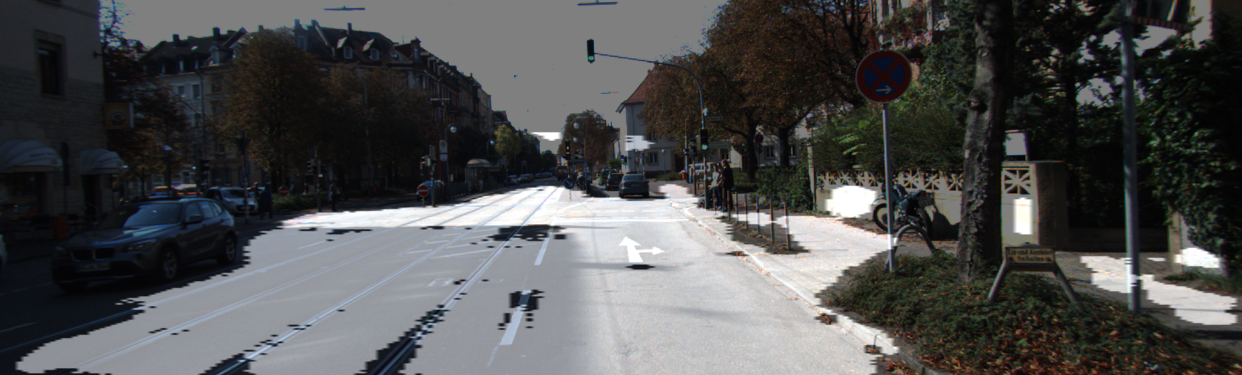

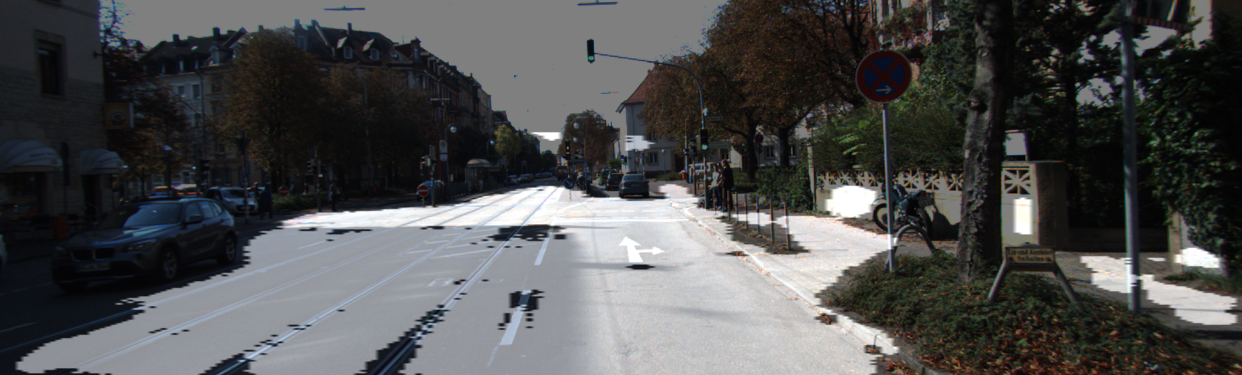

In [15]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산하게 됩니다.

IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요합니다. 

get_output을 좀 더 확장해서 output, prediction, target을 함께 리턴하도록 구현해 봅시다.

In [16]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [17]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

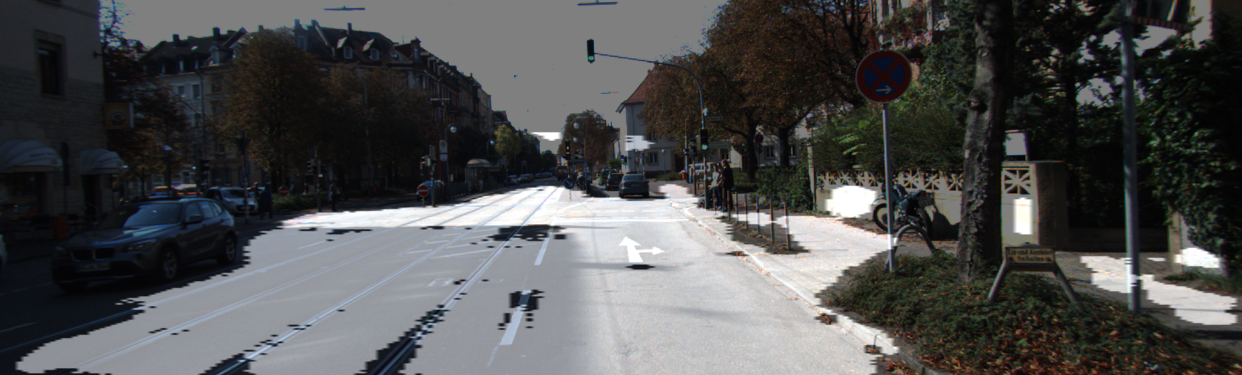

IoU : 0.745796


0.7457964449934802

In [18]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

U-Net으로 IoU를 확인했더니 0.745796이 나왔다. 

이제 U-Net++의 모델구조를 만든뒤 학습시켜 동일 이미지에대한 IoU를 재차 확인해볼 예정이다

https://arxiv.org/pdf/1912.05074.pdf

# U-Net++ 모델 구조 만들기

In [21]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.6.0
1.21.4
8.3.2
0.18.3
1.1.0


# Step 1. KITTI 데이터셋 수집과 구축


다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다.

U-Net++는 메모리 사용량이 U-Net보다 꽤 많아집니다. 그러니 배치 사이즈를 적절히 줄여서 설정하시기를 권합니다.

In [22]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self,
                dir_path,
                 batch_size=8, # 16->8로 줄였다.
                 img_size=(224,224,3),
                 output_size=(224,224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        #load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인한다
        self.data = self.load_dataset()
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png")) #전처리에 사용할 입력이미지 경로!
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png")) #정답 이미지
        
        input_images.sort()
        label_images.sort()
        
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)] #input당 label을 data에 배열로 정렬해서 넣음
        
        if self.is_train: #train이라면
            return data[:-30] # 끝에서 30개는 test용으로 남기고 나머지 모두 train
        
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        #입력과 출력을 만든다
        #입력은 resize, segmentation이 적용된 input image
        #출력은 semantic label - semantic segmentation ?
        
        batch_data = self.data[
            index * self.batch_size : (index + 1) * self.batch_size # 데이터 인덱스 슬라이싱
        ]
        inputs = np.zeros([self.batch_size , *self.img_size]) #뭐.. args만 받는다는 것인가??ㅋㅋㅋㅋ 돌겟다!!
        outputs = np.zeros([self.batch_size , *self.output_size])
        
        #print(inputs)
        
        for i , data in enumerate(batch_data):
            input_img_path , output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image" : _input,
                "mask" : _output,   
            }
            augmented = self.augmentation(**data) #kwargs만 받는다
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs
        
    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train==True:
            np.random.shuffle(self.indexes)
            return self.indexes
            

            
            
        
        
            
        
        
        
        

In [23]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)

train_generator = KittiGenerator(
    dir_path,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path,
    augmentation=test_preproc,
    is_train=False
)

# Step 2. U-Net++ 모델의 구현

U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 

이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.

그 외 적절히 U-Net의 백본 구조, 기타 파라미터 변경 등을 통해 추가적인 성능 향상이 가능할 수도 있습니다.

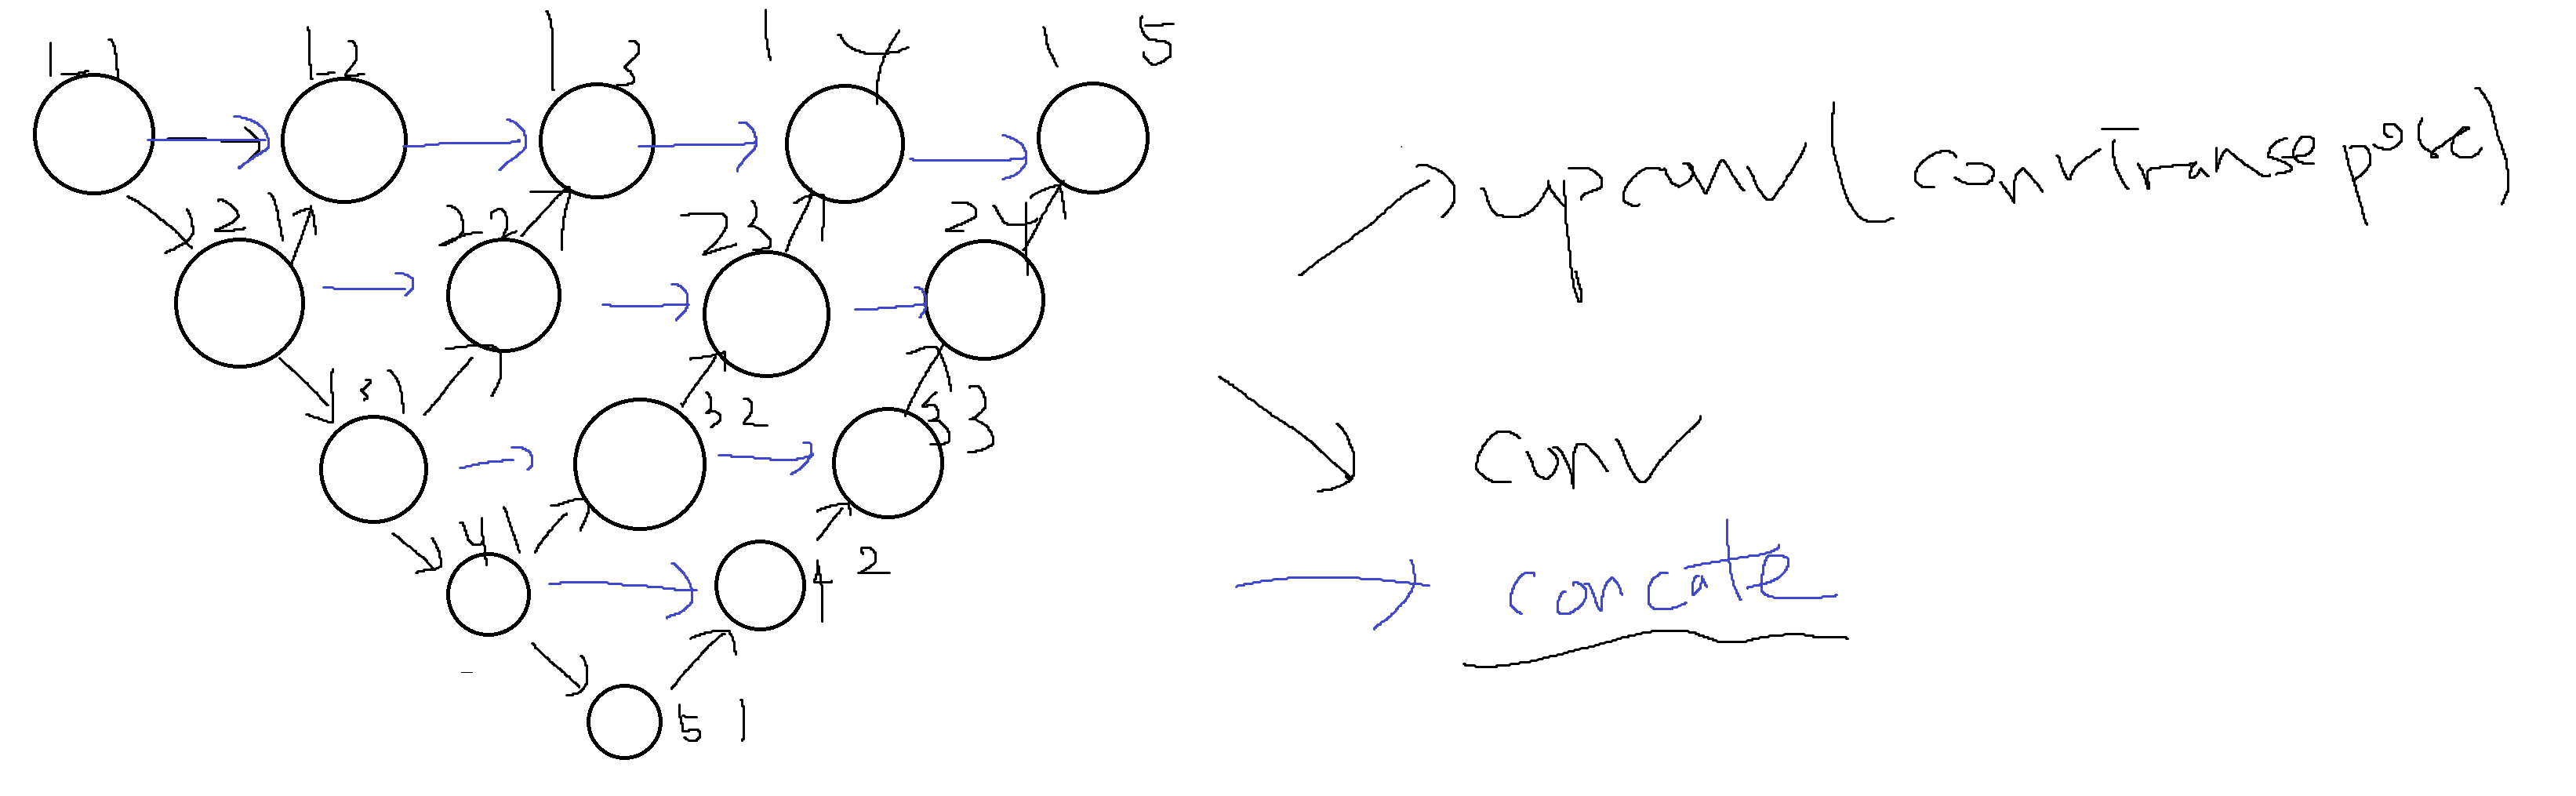

In [ ]:
def build_model_plus(input_shape=(224,224,3)):
    inputs = Input(input_shape) #224
    

    # Main Contracting Path - 5 nodes
    conv1_1 = Conv2D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal")(inputs) #224
    batch1_1 = BatchNormalization()(conv1_1)
    conv1_1 = Conv2D(64, 3, activation='relu', padding="same",kernel_initializer="he_normal")(batch1_1) #224
    pool1_1 = MaxPooling2D(pool_size=(2,2))(conv1_1) #112
    
    conv2_1 = Conv2D(128, 3, activation='relu', padding="same",kernel_initializer="he_normal")(pool1_1) #112
    batch2_1 = BatchNormalization()(conv2_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding="same",kernel_initializer="he_normal")(batch2_1) #112
    pool2_1 = MaxPooling2D(pool_size=(2,2))(conv2_1) #56
    
    #dropout?
    conv3_1 = Conv2D(256, 3, activation='relu', padding="same",kernel_initializer="he_normal")(pool2_1) #56
    batch3_1 = BatchNormalization()(conv3_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding="same",kernel_initializer="he_normal")(batch3_1) # 56
    pool3_1 = MaxPooling2D(pool_size=(2,2))(conv3_1) # 28
    
    #dropout?
    conv4_1 = Conv2D(512, 3, activation='relu', padding="same",kernel_initializer="he_normal")(pool3_1) # 28
    batch4_1 = BatchNormalization()(conv4_1)
    conv4_1 = Conv2D(512, 3, activation='relu', padding="same",kernel_initializer="he_normal")(batch4_1) # 28
    pool4_1 = MaxPooling2D(pool_size=(2,2))(conv4_1) # 14
    
    conv5_1 = Conv2D(1024, 3, activation='relu', padding="same",kernel_initializer="he_normal")(pool4_1) # 14
    batch5_1 = BatchNormalization()(conv5_1)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding="same",kernel_initializer="he_normal")(batch5_1) # 14
    
    drop5_1 = Dropout(0.5)(conv5_1)
    #Make Expanding Path as Pyramid - 4 nodes
    
    #U-net 1_2 E-Path
    upconv1_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv2_1)
    concat1_1_2 = concatenate([conv1_1, upconv1_2], axis=3)  
    conv1_2 = Conv2D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal")(concat1_1_2) #224
    batch1_2 = BatchNormalization()(conv1_2)
    conv1_2 = Conv2D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal")(batch1_2) #224
    
    #U-net 2_2 E-path
    upconv2_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv3_1) #56
    concat2_1_2 = concatenate([conv2_1, upconv2_2], axis=3) #56
    conv2_2 = Conv2D(128, 3, activation='relu', padding="same", kernel_initializer="he_normal")(concat2_1_2) #112
    batch2_2= BatchNormalization()(conv2_2)
    conv2_2 = Conv2D(128, 3, activation='relu', padding="same", kernel_initializer="he_normal")(batch2_2) #112
    
    #U-net 3_2 E-path
    upconv3_2 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv4_1)
    concat3_1_2 = concatenate([conv3_1, upconv3_2], axis=3) 
    conv3_2 = Conv2D(256, 3, activation='relu', padding="same", kernel_initializer="he_normal")(concat3_1_2) #56
    batch3_2 = BatchNormalization()(conv3_2)
    conv3_2 = Conv2D(256, 3, activation='relu', padding="same", kernel_initializer="he_normal")(batch3_2) #56
    
    #U-net 4_2 E-path
    upconv4_2 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(drop5_1)
    concat4_1_2 = concatenate([conv4_1, upconv4_2], axis=3) 
    conv4_2 = Conv2D(512, 3, activation='relu', padding="same", kernel_initializer="he_normal")(concat4_1_2) #56
    batch4_2 = BatchNormalization()(conv4_2)
    conv4_2 = Conv2D(512, 3, activation='relu', padding="same", kernel_initializer="he_normal")(batch4_2) #56
    
    #Make Expanding Path as Pyramid - 3 nodes
    
    #U-net 1_3 E-path
    upconv1_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv2_2)
    concat1_2_3 = concatenate([conv1_2, upconv1_3], axis=3)  
    conv1_3 = Conv2D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal")(concat1_2_3) #224
    batch1_3 = BatchNormalization()(conv1_3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal")(batch1_3) #224
    
    #U-net 2_3 E-path
    upconv2_3 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv3_2) #56
    concat2_2_3 = concatenate([conv2_2, upconv2_3], axis=3) #56
    conv2_3 = Conv2D(128, 3, activation='relu', padding="same", kernel_initializer="he_normal")(concat2_2_3) #112
    batch2_3 = BatchNormalization()(conv2_3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding="same", kernel_initializer="he_normal")(batch2_3) #112
    
    #U-net 3_3 E-path
    upconv3_3 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv4_2)
    concat3_2_3 = concatenate([conv3_2, upconv3_3], axis=3) 
    conv3_3 = Conv2D(256, 3, activation='relu', padding="same", kernel_initializer="he_normal")(concat3_2_3) #56
    batch3_3 = BatchNormalization()(conv3_3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding="same", kernel_initializer="he_normal")(batch3_3) #56
    
    
    #Make Expanding Path as Pyramid - 2 nodes
    
    #U-net 1_4 E-path
    upconv1_4 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv2_3)
    concat1_3_4 = concatenate([conv1_3, upconv1_4], axis=3)  
    conv1_4 = Conv2D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal")(concat1_3_4) #224
    batch1_4 = BatchNormalization()(conv1_4)
    conv1_4 = Conv2D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal")(batch1_4) #224
    
    #U-net 2_4 E-path
    upconv2_4 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv3_3) #56
    concat2_3_4 = concatenate([conv2_3, upconv2_4], axis=3) #56
    conv2_4 = Conv2D(128, 3, activation='relu', padding="same", kernel_initializer="he_normal")(concat2_3_4) #112
    batch2_4 = BatchNormalization()(conv2_4)
    conv2_4 = Conv2D(128, 3, activation='relu', padding="same", kernel_initializer="he_normal")(batch2_4) #112
    
    #Make Expanding Path as Pyramid - 1 nodes
    
    #U-net 1_5 E-path
    upconv1_5 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer="he_normal")(conv2_4)
    concat1_4_5 = concatenate([conv1_4, upconv1_5], axis=3)  
    conv1_5 = Conv2D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal")(concat1_4_5) #224
    batch1_5= BatchNormalization()(conv1_5)
    conv1_5 = Conv2D(64, 3, activation='relu', padding="same", kernel_initializer="he_normal")(batch1_5) #224
    
    conv1_5 = Conv2D(2, 3, activation='relu', padding="same", kernel_initializer="he_normal")(conv1_5)
    outputs = Conv2D(1, 1, activation='sigmoid')(conv1_5)
    
    
    
    
    #conv9_3 = Conv2D(2, 3, activation='relu', padding="same",kernel_initializer="he_normal")(conv9_2) #224
    #conv10 = Conv2D(1, 1, activation='sigmoid')(conv9_3) #1
    
    model = Model(inputs=inputs, outputs=outputs)

    return model

    
    
    
    
    

# 손실함수 dice_coef 구현하기
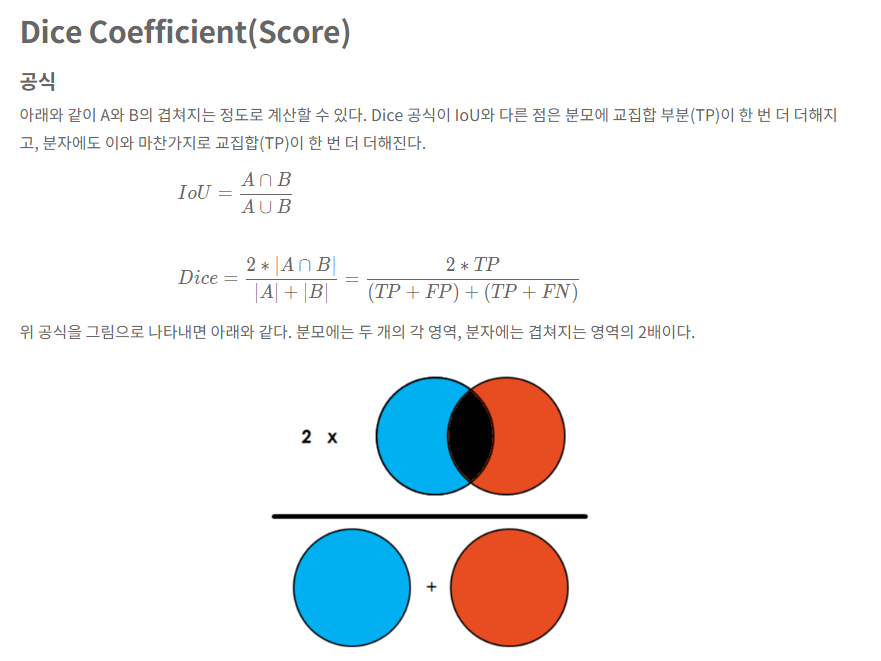

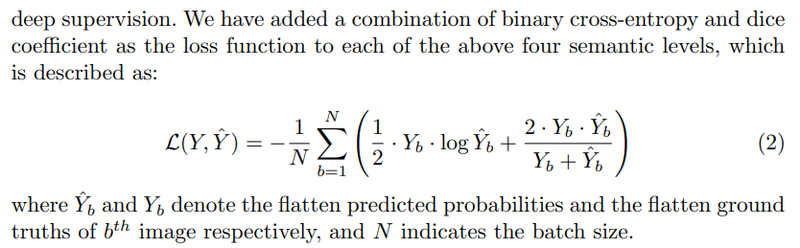

In [ ]:
from keras import backend as K
import keras

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

# U_net++ 모델 학습하기

In [45]:
model_plus_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus.h5'

model_plus = build_model_plus()
model_plus.compile(optimizer = Adam(1e-4), loss = bce_dice_loss)
model_plus.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_plus.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 20s 805ms/step - loss: 0.2061 - val_loss: 0.1808
Epoch 2/100
22/22 [==============================] - 17s 789ms/step - loss: 0.0979 - val_loss: 0.0810
Epoch 3/100
22/22 [==============================] - 17s 781ms/step - loss: 0.0899 - val_loss: 0.0772
Epoch 4/100
22/22 [==============================] - 17s 768ms/step - loss: -0.2233 - val_loss: -0.3557
Epoch 5/100
22/22 [==============================] - 17s 762ms/step - loss: -0.5251 - val_loss: -0.6751
Epoch 6/100
22/22 [==============================] - 17s 758ms/step - loss: -0.5980 - val_loss: -0.6012
Epoch 7/100
22/22 [==============================] - 17s 766ms/step - loss: -0.6848 - val_loss: -0.6231
Epoch 8/100
22/22 [==============================] - 17s 754ms/step - loss: -0.6406 - val_loss: -0.4332
Epoch 9/100
22/22 [==============================] - 17s 759ms/step - loss: -0.5567 - val_loss: -0.5691
Epoch 10/100
22/22 [==============================] - 17s 753ms/step -

KeyboardInterrupt: 

Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

두 모델의 정량적, 정성적 성능을 비교해 봅시다. 

시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

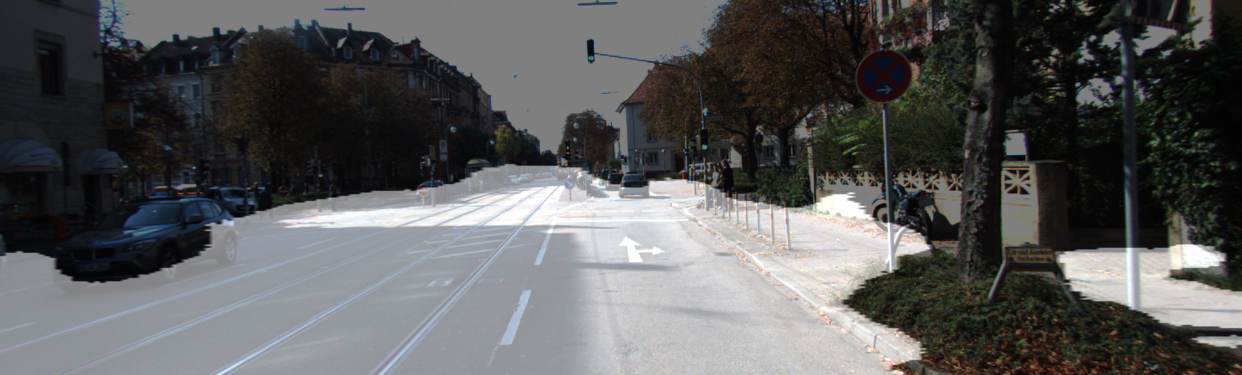

IoU : 0.742192


0.7421920692478653

In [41]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

어라라 u_net++가 성능이 더 구리다!??  u_net++ 구조를 좀더 만져야겠다!


In [46]:
model_plus2_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_plus2.h5'

model_plus2 = build_model_plus()
model_plus2.compile(optimizer = Adam(1e-4), loss = bce_dice_loss)
model_plus2.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_plus.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
22/22 [==============================] - 20s 800ms/step - loss: -0.0675 - val_loss: -0.0932
Epoch 2/100
22/22 [==============================] - 17s 789ms/step - loss: -0.2951 - val_loss: -0.3865
Epoch 3/100
22/22 [==============================] - 17s 775ms/step - loss: -0.4618 - val_loss: -0.3967
Epoch 4/100
22/22 [==============================] - 17s 764ms/step - loss: -0.5568 - val_loss: -0.4106
Epoch 5/100
22/22 [==============================] - 17s 760ms/step - loss: -0.6371 - val_loss: -0.4407
Epoch 6/100
22/22 [==============================] - 17s 773ms/step - loss: -0.6256 - val_loss: -0.4353
Epoch 7/100
22/22 [==============================] - 17s 766ms/step - loss: -0.7303 - val_loss: -0.6287
Epoch 8/100
22/22 [==============================] - 17s 759ms/step - loss: -0.7552 - val_loss: -0.5882
Epoch 9/100
22/22 [==============================] - 17s 753ms/step - loss: -0.6301 - val_loss: -0.5897
Epoch 10/100
22/22 [==============================] - 16s 746ms/

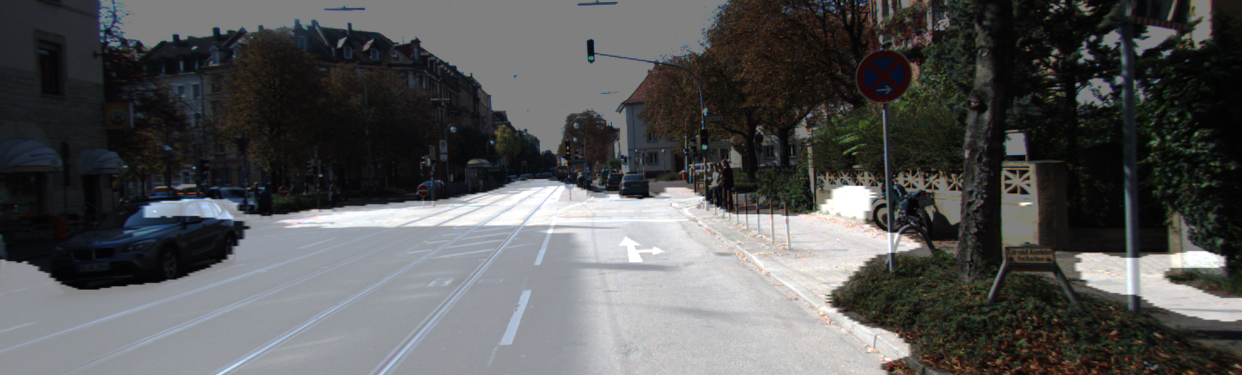

IoU : 0.808941


0.8089409945890235

In [47]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model_plus, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

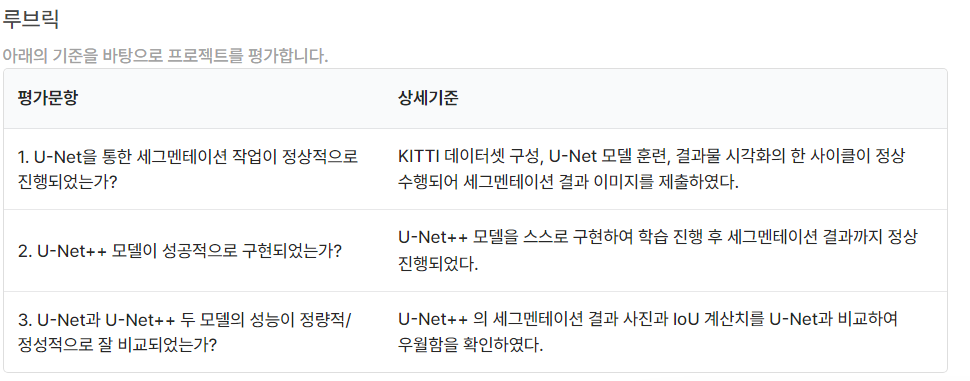

다음처럼 IoU가 U-net 기준 0.74, U-net++ 기준 0.80으로 더 높게 나옴을 확인했습니다.

기존에 U-net에 각 중간 레이어별로 upconv concate 한것과  conv와 conv사이에 batch_norm을 넣어준 것이 변경 사항입니다.

# 회고

참으로 고된 작업들인데 이 작업들을 좀더 세밀하게 하이퍼파라미터를 다뤄보고 조정하고 다른 레이어도 넣어보고 하면 0.9까지도

뽑아낼수 있지 않을까 생각해보면서 과제를 제출한다.

